<center><h1>SINGING VOICE TRANSCRIPTION USING DEEP NEURAL NETWORKS</h1></center> 

<h1><center>Implementation</center></h1>

CODE AUTHOR: Shayenne Moura, Computer Music Group, University of São Paulo/Brazil

*Original article by François Rigaud and Mathieu Radenen, ISMIR 2016.*

This notebook presents an implementation of a system for singing voice melody transcription reproduced based an article published in ISMIR 2016. This system is not the original of the paper. Since the details of implementation are not available, different results were achieved.

### Introduction

The main task of this system is to estimate the main melody, i.e., sequences of fundamental frequency ($f_0$) where voice or instrument is active.

The approach realized was based in a supervised classification problem. It means that the system need to assign a pitch class for each frame when melody is present and unvoiced class when it is not.

### System description

It was implemented a system proposed as illustrated in figure below. Two Deep Neural Networks (DNNs) are composed in parallel for identify melodic sequences in polyphonic music.

<img src="systemDNN.png" alt="Drawing" style="width: 300px;"/>

The Voice Activity Detection (VAD) DNN is responsible for decides which frames are voiced/unvoiced. The F0 estimation DNN is responsible for classify a frequency for each frame.

The implementation presented here is not the original of the published paper but based on the description given by the article and its references.

### Preprocess audio signal

In [1]:
# Import libraries and modules    
from librosa import *            # Manipulate and display audio files
import librosa.display
import scipy                     # Utilize signal functions
import matplotlib.pyplot as plt  # Plot graphics
%matplotlib inline
import numpy as np               # Manipulate arrays efficiently
import os, glob                  # Find files in directories
import IPython                   # Display audio file in notebook
import csv                       # Manipulate .csv files
import pandas as pd               # Manipulate data as matrix


# Keras modules
from keras.models import Model, Sequential, model_from_json, load_model


from utils import viterbi_alg

# Put your audio file path 
file_path = "/var/tmp/IA/MusicDelta_Rockabilly_MIX.wav" 

Using TensorFlow backend.


##### Steps of preprocess all data

1. Converted to mono
1. Re-sampled to 16kHz
1. Double-stage Harmonic/Percussive Source Separation
    - $h_1$ and $p_1$ (FFT using window of 256ms) by re-sampled signal
    - $h_2$ and $p_2$ (FFT using window of 256ms) by $p_1$ signal reconstructed
    
    
*Intuition:* This double-stage Harmonic/Percussive Source Separation [enhance? make more clear?] the separation between more stationary/stable sounds (the harmonic background) and more percussive instruments (such as drum). Melodic signals are usually present on $h_2$ spectrogram.

In [2]:
print ("--- Preprocessing...")
print (file_path)
    
# Preprocess audio signal
y, sr = librosa.load(file_path, mono=True) # Converted to mono
y_16k = librosa.resample(y, sr, 16000)
sr = 16000

print ("> Audio signal loaded...")

# Applying HPSS separation
# High frequency resolution - more clearly the frequencies
print ("> First HPSS decomposition (high-frequency resolution)...")

# STFT with Hamming window of 256ms (4096 samples) with overlap 0,75 (hop 0.25)
s = librosa.stft(y_16k, n_fft=4096, hop_length=int(4096/4), window=scipy.signal.hamming(4096))
h1, p1 = librosa.decompose.hpss(s)
    
    
# P1 here has other frequency resolution
print ("> Second HPSS decomposition (high-frequency resolution)...")
# Getting signal - need arguments of stft
p1_inverse = librosa.istft(p1, hop_length=int(4096/4), window=scipy.signal.hamming(4096))
h1_inverse = librosa.istft(h1, hop_length=int(4096/4), window=scipy.signal.hamming(4096))


# STFT with Hamming window of 32ms (512 samples) with overlap 0,75 (hop 0.25)
p1_32 = librosa.stft(p1_inverse, n_fft=512, hop_length=int(512/4), window=scipy.signal.hamming(512))
h2, p2 = librosa.decompose.hpss(p1_32)   

# Getting signal separated - need arguments of stft
h2_inverse = librosa.istft(h2, hop_length=int(512/4), window=scipy.signal.hamming(512))
p2_inverse = librosa.istft(p2, hop_length=int(512/4), window=scipy.signal.hamming(512))

--- Preprocessing...
/var/tmp/IA/MusicDelta_Rockabilly_MIX.wav
> Audio signal loaded...
> First HPSS decomposition (high-frequency resolution)...
> Second HPSS decomposition (high-frequency resolution)...


##### Steps of preprocess for VAD

For each of the reconstructed signals $h_1$, $h_2$ and $p_2$, timbral features are computed:
   - MFCCs with 32ms Hamming windows, 0.75 of overlap, 40 triangular filters on mel scale between 0 and 8kHz.
   - Normalized using mean and variance for each coefficient

In [3]:
""" Input for VAD """    
# The input for VAD is the whole signal s = h1 + h2 + p2 in MFCC features
h1_mfcc = librosa.feature.melspectrogram(y=h1_inverse, sr=sr, n_fft=512, hop_length=128, n_mels=40, fmax=8000)
h2_mfcc = librosa.feature.melspectrogram(y=h2_inverse, sr=sr, n_fft=512, hop_length=128, n_mels=40, fmax=8000)
p2_mfcc = librosa.feature.melspectrogram(y=p2_inverse, sr=sr, n_fft=512, hop_length=128, n_mels=40, fmax=8000)
    
# Write mfcc file (PRECISA DISSO???)
with open(file_path[:-4]+'_mfcc.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    col = h1_mfcc.shape[1]
    row = np.ndarray(shape=(3*40,))
    for i in range(col):
        row[  :40] = h1_mfcc[:,i]
        row[40:80] = h2_mfcc[:,i]
        row[80:  ] = p2_mfcc[:,i]
        spamwriter.writerow(row) ### Put the mfcc from h1+h2+p2

##### Steps of preprocess for F0-estimation

For each signal $p_1$, the features selected are:
   - Log-spectrograms with 64ms Hamming windows and 0.75 of overlap [without discarting]
   - Rescaled between 0 and 1

In [4]:
""" Input for F0-Detection """    
# Getting signal - need arguments of stft - Discarting frequencies?
p1_toF0_inverse = librosa.istft(p1, hop_length=int(4096/4), window=scipy.signal.hamming(4096))

# STFT with Hamming window of 64ms (1024 samples) with overlap 0,75 (hop 0.25)
p1_toF0 = librosa.stft(p1_toF0_inverse, n_fft=1024, hop_length=int(1024/4), window=scipy.signal.hamming(1024))
# Log-spectrogram
p1_toF0_log = librosa.amplitude_to_db(p1_toF0, ref=np.max)
    
## Rescale done for F0 Detection Model (Not cutted)
p1_toF0_log = p1_toF0_log - p1_toF0_log.min()
p1_toF0_log = p1_toF0_log / p1_toF0_log.max()  
    

# Write features file 
with open(file_path[:-4]+'_features.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    col = p1_toF0_log.shape[1]
    for i in range(col):
        spamwriter.writerow(p1_toF0_log[:,i])

### Training Step

### VAD Training


### F0-estimation Training

# Making Predictions

The melodic line was given by the result of these two DNNs composed.

### VAD results 

The voice estimation is done by the following steps:

 1. Load and compile the VAD DNN;
 1. Load the features of the music to be estimated;
 1. Normalize the features to feed the DNN;
 1. Predict the probability to be voiced;
 1. Threshold frames with probability greater than 0.5 as voiced.

In [5]:
# load json and create model
json_file = open('25SVDmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_svd = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_svd.load_weights("25SVDmodel.h5")
print("Loaded model from disk")

# compile loaded model with the same parameters
loaded_model_svd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [6]:
# load best weights into new model
loaded_model_svd.load_weights("weights.best.hdf5")
print("Loaded model from disk")

# compile loaded model with the same parameters
loaded_model_svd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [7]:
# Load data to classify
df1 = pd.read_csv(file_path[:-4]+"_mfcc.csv", header=None)
X = pd.DataFrame.as_matrix(df1)
print (X.shape)

(3241, 120)


In [8]:
# Data Normalization - necessary! (Better results on network training) 
meanDF = X - np.mean(X, axis=0).reshape(1, X.shape[1])
X  = meanDF / np.std(meanDF, axis=0).reshape(1, X.shape[1])

In [9]:
# calculate predictions
voiced = loaded_model_svd.predict(X)

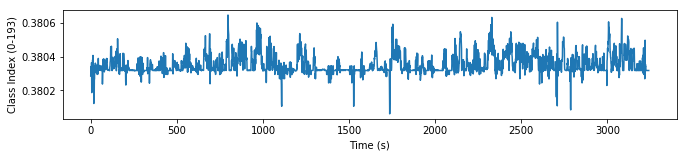

In [10]:
# Plot probability of voice presence
plt.figure(figsize=(11,2))
plt.plot(voiced)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

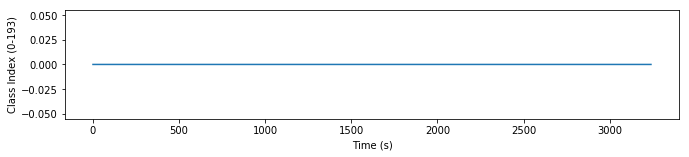

In [32]:
# Activation output - need to be 0.5
vcd = voiced.copy()
vcd[vcd <  0.5] = 0
vcd[vcd >= 0.5] = 1

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(vcd)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### Measures to evaluate the result

Following cells makes a small evaluation of the results from VAD DNN.

First, load the piece labels to compare with the voice estimated here.

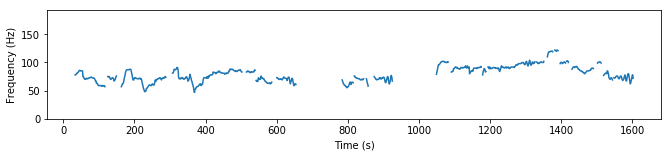

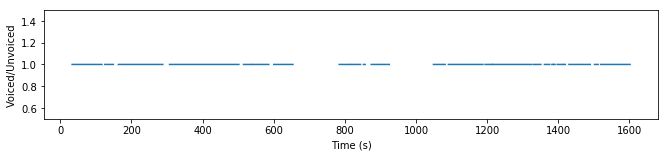

In [28]:
# Get labels to compare
annot = "/var/tmp/IA/labels/MusicDelta_Rockabilly_labels.csv"

labels = [] # Notes are present
lbl    = [] # Only voiced/unvoiced

with open(annot) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels.append(float(row[0]))
        
for i in range(len(labels)):
    if labels[i] <= 0:
        labels[i] = None
        lbl.append(None)
    else:
        lbl.append(1)
        
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

# Plot voiced line from annotation
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0.5,1.5])
plt.plot(lbl[::2])
plt.xlabel('Time (s)')
plt.ylabel('Voiced/Unvoiced')
plt.show()

Now, are calculated TN (true negatives), TP (true positives), FN (false negatives), FP (false positives) to evaluate.

Comparing different measures:
 1. P: Precision
 1. R: Recall
 1. F: F-measure
 1. FA: False Alarm Rate
 1. VA: Voicing Accuracy
 1. OA: Overall Accuracy

In [35]:
# We have the same value of voiced frames and labeled frames!!!
TN, TP, FN, FP = 0, 0, 0, 0

res = vcd.copy()
res[vcd <  0.5] = None

for j in range(len(vcd)):
    if res[j] is None:
        if lbl[j] == res[j]:
            TN += 1
        else:
            FN += 1

    if lbl[j] is not None:
        if lbl[j] == res[j]:
            TP += 1
    
    elif res[j] is 1:
        FP += 1
        
        
print ("Precision", TP/(TP+FP))
print ("Recall", TP/(TP+FN))
print ("Voicing Recall Rate:", TP/(TP+FN))
print ("Voicing False Alarm Rate:", FP/(TN+FP))  
### Calculate the overal accuracy

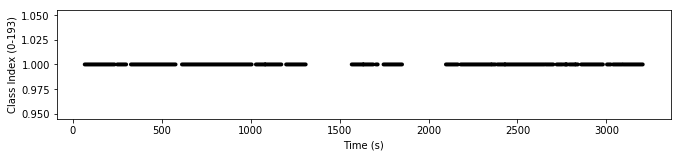

In [31]:
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(lbl, solid_capstyle="round", linewidth=4, color='black')
plt.plot(res, solid_capstyle="round", linewidth=2, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### F0 prediction

The f0-line estimation is done by the following steps:

 1. Load and compile the F0-estimation DNN;
 1. Load the MFCCs of the music to be estimated;
 1. Normalize the features to feed the DNN (made on preprocess); 
 1. Predict the probability distribution for each frame;
 1. Get the most probable class on this distribution;
 1. Apply Viterbi algorithm to smooth the estimated line.

In [14]:
# Load json and create model
json_file = open('f0model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_f0 = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model_f0.load_weights("f0model.h5")
print("Loaded model from disk")
 
# Compile loaded model with the same parameters
loaded_model_f0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [15]:
# Load data to classify
df1=pd.read_csv(file_path[:-4]+"_features.csv",header=None)
X=pd.DataFrame.as_matrix(df1)
print (X.shape)

(1621, 513)


In [16]:
# Calculate predictions
predictions = loaded_model_f0.predict(X)

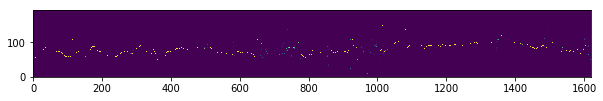

In [17]:
# Plot the grid
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(predictions), origin='lower')
plt.show()

In [18]:
# Max probability line
ynotes = np.argmax(np.transpose(predictions), axis=0)

In [19]:
####    Viterbi post processing    ###

# Log-probabilities matrix
trans_mtx = np.ones((193 ,193))
for k in range(193):
    for l in range(193):
        trans_mtx[k][l] = 1/abs(k-l+0.1)

# Make the signal smooth
best_path_ind, paths, log_probs = viterbi_alg(trans_mtx, trans_mtx, ynotes)
print ("obs1 is " + str(ynotes))
print ("obs1, best path is" + str(paths[best_path_ind,:]))

obs1 is [77 25 92 ..., 51 88 88]
obs1, best path is[ 76.  77.  77. ...,  52.  88.  89.]


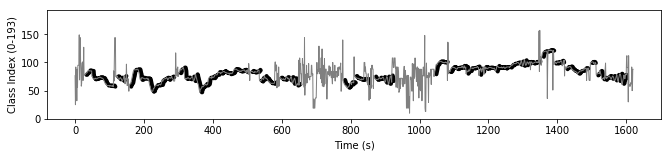

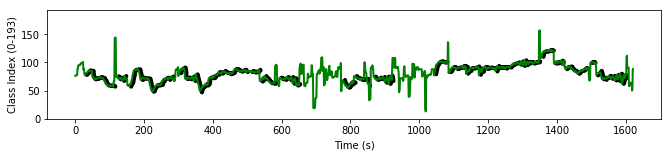

In [20]:
# Plot melodic line from annotation and result
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2], solid_capstyle="round", linewidth=4, color='black')
plt.plot(ynotes, solid_capstyle="round", linewidth=1, color='gray')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2], solid_capstyle="round", linewidth=4, color='black')
plt.plot(paths[best_path_ind,:], solid_capstyle="round", linewidth=2, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### Measures to evaluate F0-estimation results


Following cells makes a small evaluation of the results from F0-estimation DNN.

Comparing different measures (with and without Viterbi tracking):
 1. RPA: Raw Pitch Accuracy
 1. RCA: Raw Chroma Accuracy

In [21]:
# RAW PITCH ACCURACY (error less than a half of a semitone)
# How the classes are done for represent an eight of tone, if the error of estimation
# is in the range {f0-2, f0+2}, the estimation is correct. res = ynotes
lbl = labels[::2]
res = ynotes
acc = 0
vstar = 0

for j in range(len(ynotes)):
    if lbl[j] is not None:
        vstar += 1
        if res[j] >= lbl[j]-2 and res[j] <= lbl[j]+2:
            acc += 1
    
print ("Raw Pitch Accuracy:", acc/vstar)   
## Calculate the RCA

Raw Pitch Accuracy: 0.5103806228373703


In [22]:
# RAW PITCH ACCURACY (error less than a half of a semitone)
# How the classes are done for represent an eight of tone, if the error of estimation
# is in the range {f0-2, f0+2}, the estimation is correct. res = ynotes
lbl = labels[::2]
res = paths[best_path_ind,:]
acc = 0
vstar = 0

for j in range(len(ynotes)):
    if lbl[j] is not None:
        vstar += 1
        if res[j] >= lbl[j]-2 and res[j] <= lbl[j]+2:
            acc += 1
    
print ("Raw Pitch Accuracy:", acc/vstar)    

Raw Pitch Accuracy: 0.5622837370242214


### Final result

The complete estimation is composed by the DNNs results: **The note estimated when voice is present**

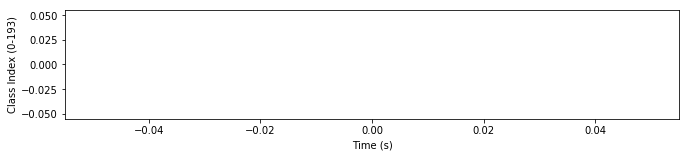

In [37]:
# We have doubled vocal answers
final = []

for j in range(len(ynotes)):
    final.append(vcd[::2][j]*float(paths[best_path_ind,:][j]))
    if final[j] == 0:
        final[j] = None

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(final)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()